# Predicting Logerror
by: Deangelo Bowen

---

## Project Overview and Goals:




### Overview:

The focus of this project is to use the 2017 properties and predictions data for single unit / single family homes to  uncover what the drivers of the error in the zestimate is.

### Goals: 

- Construct a ML regression model with clustering techniques that can predict logerror for Single Unit/Family properties that had a transaction in 2017 using defining features for those properties. 
- Find the Key Drivers of that logerror
- Make recommendations on what works or what doesn't work when predicting logerror.

### Executive Summary:

#### When observing general home features such as bedrooms and bathrooms: 
   - There is some linear correlation between number of bedrooms and logerror.
   - There is some linear correlation between number of bathrooms and logerror.

#### When controlling for county:
   - There is a significant difference between Los Angeles Logerror and the population logerror.
   - There is a significant difference between Ventura Logerror and population logerror.
   - There is no significant difference, or no difference between Orange County Logerror and the population logerror.

#### When observing age of property: 
 - There is a linear correlation between the age of the property and logerror.

#### When controlling for property type:
   - Townhomes and Mobile home data sample were too small to perform any meaningful statistical operations.
   - No linear correlation between type single family residential's year built, and logerror.
   - Strong postive linear correlation between the year condiminums were built and logerror. (P value .96)

##### I would recommend pursuing further identifications of key drivers for logerror to potentially construct better accurate predictors as none of the current models beat the baseline.

---

## Imports

In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#imports for user defined functions
from env import host, user, password, get_db_url

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#imports for splitting data and imputing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
import statistics

import viz

from pydataset import data

import wrangle as wr
import explore as ex

np.random.seed(4)

# acquire zillow dataset from SQL server
zillow = wr.acquire()

---

### Wrangling the Zillow dataset:

## SQL : 
#### To acquire the needed features from the SQL server, I :
> SELECT 
prop.*

#### From properties_2017

> LEFT JOIN airconditioningtype air USING (airconditioningtypeid)

#### ....and many other features that can be found in the wrangle.py file.

---

### Looking at the observed DataFrame : 

In [2]:
# calls the first 5 rows of the zillow dataset
zillow.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


### Observation Takeaways: 
#### The original dataframe contained 77380 rows and 68 columns.

#### However...
1. Data needs to be restricted to only inclue single family properties
2. Columns that are deemed unnecessary or that contain more than 50% nulls need to be dropped.
3. Outliers that infringe data integrity also need to be removed. 
4. Column naming conventions need to be proper and easily recognizable. 
5. Bedroms and bathroom outliers were changed where bedrooms or bathrooms would equal 0, as these are not representitive of a family home as outlined : [CHAPTER 96. - SINGLE- AND MULTI-FAMILY HOUSING CODE, of the Code of Ordinances](https://library.municode.com/tx/carrollton/codes/code_of_ordinances?nodeId=TITIXHESAPRMA_CH96SIULMIHOCO)
6. As I outlined in a goal from the previous project, I created a property_age column that displays the age of the home in 2017. 

After altering the dataframe to better match the vision of these goals it returned:

- 66,634 Rows
- 10 Columns

### Finally, before moving into Exploratory Analysis:
- I obtained a train, validate, test dataset
- Observed only:
    - Bedrooms
    - Bathrooms
    - Square Feet
    - County
    - Year built
    - Property Type
    - Home Value

In [3]:
# split into train validate test and observe the first 5 rows of the dataset
train, validate, test = ex.split_data()
train.head()

,parcelid,logerror,bathrooms,bedrooms,square_feet,county,year_built,property_type,home_value
35021,12456239,0.110467,1.0,1,480,Los Angeles,1942,Single Family Residential,45881.0
5579,12864000,0.000151,4.0,5,2828,Los Angeles,1962,Single Family Residential,148451.0
71705,14733743,0.054847,2.5,2,1150,Orange,1998,Condominium,311854.0
57277,17075614,0.092856,3.0,3,2046,Ventura,1990,Single Family Residential,796305.0
45925,11177880,-0.041157,2.0,2,1028,Los Angeles,1985,Single Family Residential,270563.0


### These 3 datasets allow:
- Myself to train the data and observe distributions and perform statistical tests.
- Validate that the data has been trained properly
- Proceed to test the ML models constructed on new data.

---

# Exploratory Analysis

#### I'll start by looking at the features in my altered dataframe that have a relatonship with logerror. 

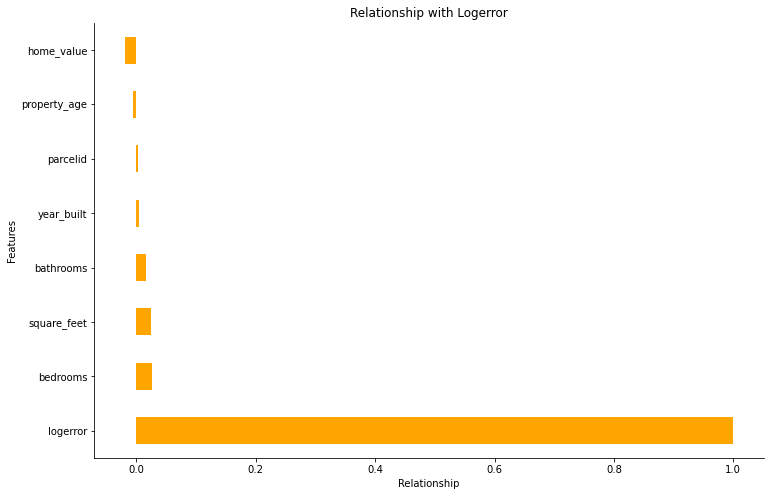

In [40]:
# correlation function that takes a dataframe and returns a correlation graph
ex.corr_graph(train)

#### Takeaways : 
- At first glance, there isn't any features that have a visually storng positive relationship with logerror, however, there is some relationship.

#### This is mostly found in:
- Bedrooms 
- Sqaure feet 
- Bathrooms 

---

## Exploratory Analysis :  Questions :

Moving forward with the Exploratry Analysis I asked a number of questions that might solidify direction on how to percieve this dataset. 

#### Those questions were: 
- Is log error linearly correlation with number of bathrooms?
    - Bedrooms?
- Is log error significantly different in each: Average sqaure feet in LA, Orange, and Ventura? 
- Is log error linearly correlated with age of a property? 
- Is log error significantly different depending on the type of property.

---

#### Before moving to observed these questions, I had to calculate the age of a property to properly observe the 4th question.

In [5]:
# function that sets the age of a home by subtracting it's 
# year built by 2017

ex.set_home_age(train, validate, test)

#### Following that, an Alpha needed to be set for statistical testing. This Alpha represented that each statistical test would be operating on a 95% confidence level.

In [6]:
# alpha 0.05 = 95% confidence
alpha = 0.05

---

## Question 1: Is log error linearly correlation with number of bathrooms or bedrooms?

### Bathrooms

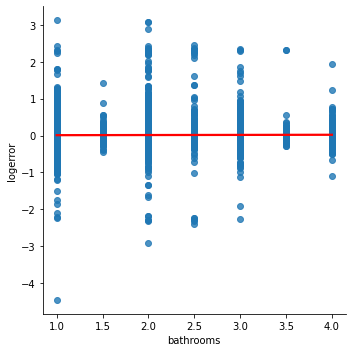

In [7]:
# lmplot function that takes in a dataframe and returns an lmplot
ex.bath_and_logerror(train)

### Statistical Test (Pearson's R) and Null Hypothesis:
$H_0$: There is no linear correlation between logerror and number of bedrooms

$H_a$: There is a linear correlation between logerror and number of bedrooms

In [8]:
# correlation testing using pearsons r
corr, p = stats.pearsonr(train.bathrooms, train.logerror)

if p < alpha: 
    print('I reject the null hypothesis.')
else:
    print('I fail to reject the null hypothesis.')

I reject the null hypothesis.


### Bedrooms

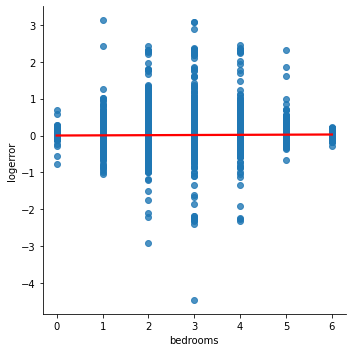

In [9]:
# lmplot function that takes in a dataframe and returns an lmplotv
ex.beds_and_log(train)

### Statistical Test (Pearson's R) and Null Hypothesis:
$H_0$: There is no significant difference between number of bedrooms and logerror.

$H_a$: There is a significant difference between number of bedrooms and logerror.

In [10]:
# correlation testing using pearsonsr 
corr, p = stats.pearsonr(train.logerror, train.bedrooms)
corr, p

if p < alpha: 
    print('I reject the null hypothesis that there is no significant difference between number of bedrooms and logerror.')
else:
    print('I fail to reject the null hypothesis.')

I reject the null hypothesis that there is no significant difference between number of bedrooms and logerror.


### Question 1 Takeaways:
- There is some linear correlation between number of bedrooms and bathrooms with logerror.

---

## Question 2 :  Is log error significantly different in each: Average sqaure feet in LA, Orange, and Ventura? 

#### To do this, I had to control for county :

In [11]:
# attributing variables to a dataframe that contains only a specific county
la = train[train.county == 'Los Angeles']
orange = train[train.county == 'Orange']
ventura = train[train.county == 'Ventura']

##### Upon discovering that there was no equal variance between the population logerror and the county logerror, a mannwhiteney-u test was decided upon with the alternative set to 'two-sided'

### Los Angeles Logerror and Population Logerror:

$H_0$: There is no significant difference between Los Angeles Logerror and population logerror. 

$H_a$: There is a significant difference between Los Angeles logerror and population logerror.

In [12]:
# stats testing using mann whiteney-u
t, p = stats.mannwhitneyu(la.logerror, 
                          train.logerror, alternative='two-sided')
if p < alpha:
    print('I reject the null hypothesis that there is no difference.')
else:
    print('I fail to reject the null hypothesis. There is a significant difference.')

I fail to reject the null hypothesis. There is a significant difference.


### Takeaway 1:
- There is a significant difference between Los Angeles Logerror and the population logerror.

### Ventura County Logerror and Population Logerror:

$H_0$: There is no significant difference between Los Angeles Logerror and population logerror. 

$H_a$: There is a significant difference between Los Angeles logerror and population logerror.

In [13]:
# stats testing using mann whiteney-u
t, p = stats.mannwhitneyu(ventura.logerror,
                          train.logerror, alternative='two-sided')

if p < alpha:
    print('I reject the null hypothesis that there is no difference.')
else:
    print('I fail to reject the null hypothesis. There is a significant difference.')

I fail to reject the null hypothesis. There is a significant difference.


### Takeaway 2 :
- There is a significant difference between Ventura Logerror and population logerror.

### Orange County and Population Logerror:

$H_0$: There is no significant difference between Orange County Logerror and population logerror.

$H_a$: There is a significant difference between Orange County logerror and population logerror

In [14]:
# stats testing using mann whiteney-u
t, p = stats.mannwhitneyu(orange.logerror, train.logerror, alternative='two-sided')

if p < alpha:
    print('I reject the null hypothesis that there is no difference.')
else:
    print('I fail to reject the null hypothesis. There is a significant difference.')

I reject the null hypothesis that there is no difference.


### Takeaway 3:
- There is no significant difference, or no difference between Orange County Logerror and the population logerror.

### Question 2 Takeaways, Summary : 
- There is a significant difference between Los Angeles Logerror and the population logerror.
- There is a significant difference between Ventura Logerror and population logerror.
- There is no significant difference, or no difference between Orange County Logerror and the population logerror

---

## Question 3, Is log error linearly correlated with age of a property? :

<Figure size 1152x576 with 0 Axes>

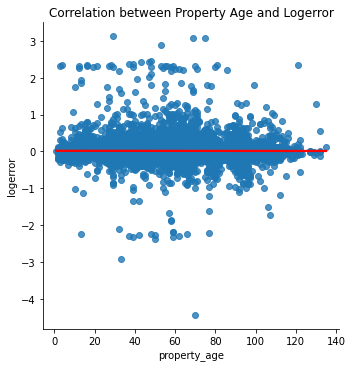

In [15]:
# lmplot function found in explore.py
ex.age_and_logerror(train)

### Statistical Test (Pearson's R) and Null Hypothesis:
$H_0$: There is no linear correlation between Property Age and Logerror

$H_a$: There is a linear correlation between property age and logerror

In [16]:
# stats testing using pearsonsr
corr, p = stats.pearsonr(train.property_age, train.logerror)

if p < alpha:
    print('I reject the null hypothesis that there is no linear correlation.')
else:
    print('I fail to reject the null hypothesis, there is a linear correlation')

I fail to reject the null hypothesis, there is a linear correlation


### Takeaways:
- There is a linear correlation between the age of the property and logerror.

## Question 4, While controlling for property type, is there a linear correlation between the year the home was built and logerror?

#### First I had to control for property type:
- Single Family Residents
- Condominium
- Town Homes
- Mobile Homes

However, Mobile and Town homes sample size were too small, so they were removed from any statistical testing.

In [17]:
# attributing variables to a specific dataframe 
single_family = train[train.property_type == 'Single Family Residential']
condo = train[train.property_type == 'Condominium']

types = ['Single Family Residential', 'Condominium']

### Condominium Type Homes

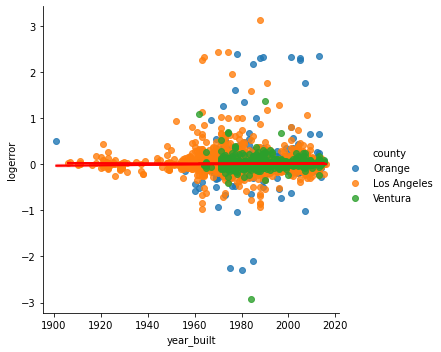

In [18]:
# creates an lmplot that takes in the condo dataframe
sns.lmplot(data=condo, x='year_built', y='logerror', line_kws={'color':'red'}, 
           hue='county')

### Statistical Test (Pearson's R) and Null Hypothesis:

$H_0$: There is no significant difference between the type of property and logerror

$H_a$: There is a significant difference between logerror and type of property.

In [19]:
# stats testing using pearsonsr
corr, p = stats.pearsonr(condo.year_built, condo.logerror)

if p < alpha:
    print('I reject the null hypothesis that there is no linear correlation.')
else:
    print('I fail to reject the null hypothesis, there is a linear correlation')

I fail to reject the null hypothesis, there is a linear correlation


### Takeaways:
  - Discovered a strong postive linear correlation between a condo home's year built and it's P value. P value returned at .96

### Single Family Residentials

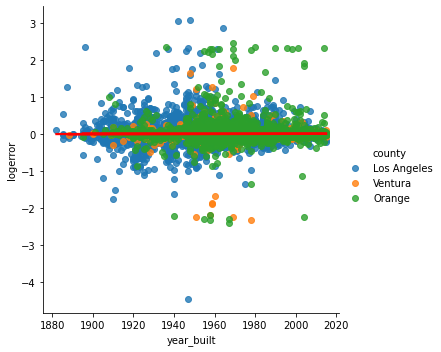

In [20]:
# lmplot that takes in the single family dataframe
sns.lmplot(data=single_family, x='year_built', y='logerror', line_kws={'color':'red'}, 
           hue='county')

In [21]:
# statistical testing using pearsonsr
corr, p = stats.pearsonr(single_family.year_built, single_family.logerror)

if p < alpha:
    print('I reject the null hypothesis that there is no linear correlation.')
else:
    print('I fail to reject the null hypothesis, there is a linear correlation.')

I reject the null hypothesis that there is no linear correlation.


### Takeaways:
- No linear correlation between type single family residential's year built, and logerror.

---

### Exploration Summary and Key Takeaways:
#### When observing general home features such as bedrooms and bathrooms: 
   - There is some linear correlation between number of bedrooms and logerror.
   - There is some linear correlation between number of bathrooms and logerror.

#### When controlling for county:
   - There is a significant difference between Los Angeles Logerror and the population logerror.
   - There is a significant difference between Ventura Logerror and population logerror.
   - There is no significant difference, or no difference between Orange County Logerror and the population logerror.

#### When observing age of property: 
 - There is a linear correlation between the age of the property and logerror.

#### When controlling for property type:
   - Townhomes and Mobile home data sample were too small to perform any meaningful statistical operations.
   - No linear correlation between type single family residential's year built, and logerror.
   - Strong postive linear correlation between the year condiminums were built and logerror. (P value .96)

---

# Clustering

Before Clustering can be done, I must scale the data and create copies.

### Scaling data

In [41]:
# scaling the data using a MinMaxScaler
train_scaled, validate_scaled, test_scaled = wr.scale_data(train, validate, test)

df = train_scaled.copy()
df=df.reset_index()

#### Now to Cluster the data, I split it into two different Clusters:

### Property Size Cluster:
The Clustering of: 
- Square Feet
- Number of Bedrooms
- Number of Bathrooms

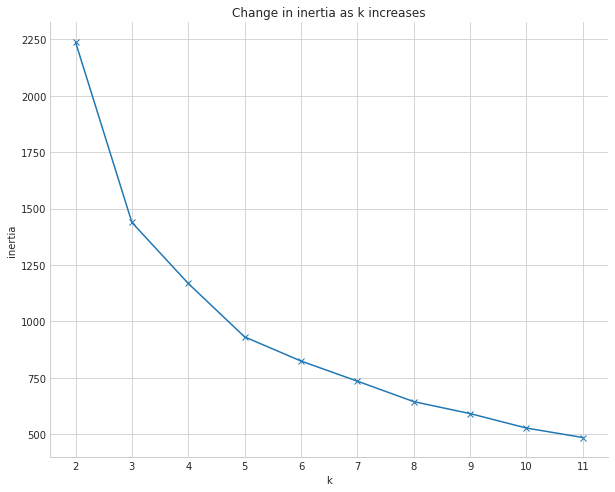

In [23]:
# clustering inertia function
X = df[['square_feet', 'bedrooms', 'bathrooms']]


with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Property Age Cluster:
The Clustering of: 
- Property Age
- Year Built

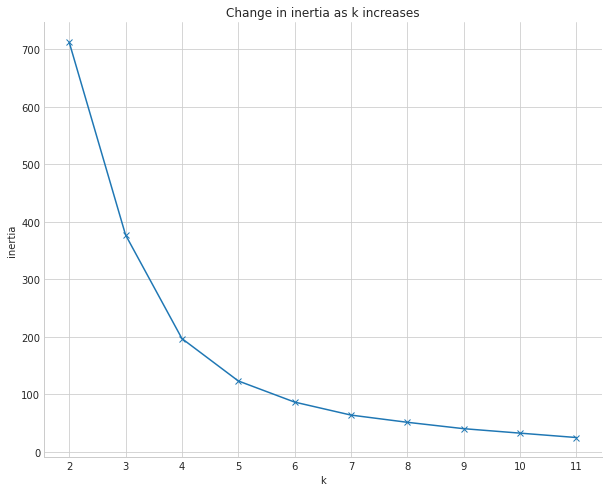

In [24]:
# Clustering inertia function for property age
X2 = df[['property_age', 'year_built']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,8))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Takeaways :
- Observing the change in inertia of both charts, setting n_clusters to 4 seemed to be the best option. 

---

# Modeling

#### Identifying the MVP:

In [25]:
# identifying mvp columns
mvp = ['bedrooms', 'bathrooms', 'square_feet', 'year_built', 'home_value',
       'property_age']

#### Scaling the MVP:

In [26]:
# setting X and Y variables for modeling
X_train, y_train = train_scaled[mvp], train_scaled.logerror
X_validate, y_validate = validate_scaled[mvp], validate_scaled.home_value
X_test, y_test = test_scaled[mvp], test_scaled.home_value

### Now I will set both clusters to train dataframe and proceed to modeling

### Property Size

In [27]:
# property size cluster

#Create the KMeans model

cols = ['square_feet', 'bedrooms', 'bathrooms']

X = X_train[cols]

kmeans = KMeans(n_clusters = 4)

#Fit the model
kmeans.fit(X)

#Make predictions and assign the values to the original train data set
X_train['property_size_cluster'] = kmeans.predict(X)

# create dataframe with centroids and columns
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
X_train.groupby('property_size_cluster')['square_feet', 'bedrooms', 'bathrooms'].mean()



# Now for validate
X = X_validate[cols]

X_validate['property_size_cluster'] = kmeans.predict(X)

# Then test
X = X_test[cols]
X_test['property_size_cluster'] = kmeans.predict(X)

### Visualizing the Cluster Centers

Text(0.5, 1.0, 'Visualizing Cluster Centers')

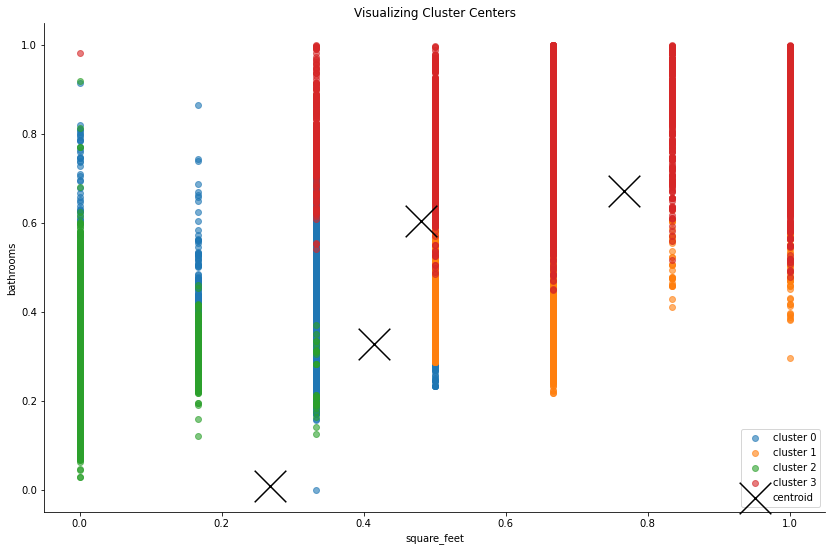

In [28]:
# visualzing cluster centers
plt.figure(figsize=(14,9))
for cluster, subset in X_train.groupby('property_size_cluster'):
    plt.scatter(subset.bathrooms, subset.square_feet, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='bathrooms', x='square_feet',
                       c='black', marker='x', s=1000, ax=plt.gca(),
                       label='centroid')

plt.legend()
plt.title('Visualizing Cluster Centers')

### Age of Property Cluster

In [30]:
cols2 = ['property_age', 'year_built']

X2 = X_train[cols2]

#Create the KMeans model
kmeans = KMeans(n_clusters = 3)

#Fit the model
kmeans.fit(X2)

#Make predictions and assign the values to the original train data set
X_train['age_cluster'] = kmeans.predict(X2)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X2.columns)
X_train.groupby('age_cluster')['property_age', 'year_built'].mean()

X2 = X_validate[cols2]

X_validate['age_cluster'] = kmeans.predict(X2)

X2 = X_test[cols2]
X_test['age_cluster'] = kmeans.predict(X2)

### Visualizing Property Age Cluster Centers

Text(0.5, 1.0, 'Visualizing Cluster Centers')

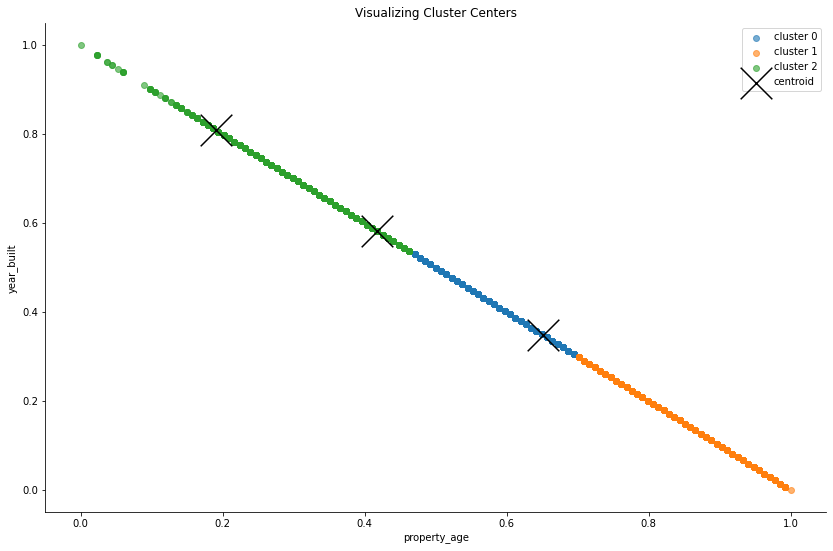

In [31]:
plt.figure(figsize=(14,9))
for cluster, subset in X_train.groupby('age_cluster'):
    plt.scatter(subset.year_built, subset.property_age, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='year_built', x='property_age',
                       c='black', marker='x', s=1000, ax=plt.gca(),
                       label='centroid')

plt.legend()
plt.title('Visualizing Cluster Centers')

### Now that the clusters are set and ready to go, I will move on to creating the baseline and constructing some ML models.

### Create the baseline: 

In [32]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test =pd.DataFrame(y_test)

# Create new data frame to hold my in sample predictions and the same for out of sample
pred_train = y_train.copy()
pred_train = pred_train.rename(columns={'logerror':'actual'})
pred_validate = y_validate.copy()
pred_validate = pred_validate.rename(columns={'home_value':'actual'})
pred_test = y_test.copy()
pred_test = pred_test.rename(columns={'home_value':'actual'})


#Calculate based on mean and add baseline predictions to a the train data frame holding predictions
baseline_mean = train.logerror.mean()
pred_train['baseline_mean'] = baseline_mean
pred_validate['baseline_mean'] = baseline_mean
pred_test['baseline_mean'] = baseline_mean

#Calculate based on median and add baseline predictions to the train data frame holding predictions
baseline_median = train.logerror.median()
pred_train['baseline_median'] = baseline_median
pred_validate['baseline_median'] = baseline_median
pred_test['baseline_median'] = baseline_median

### Calculate the RMSE of the baseline mean

In [33]:
# RMSE of baseline mean
rmse_train = mean_squared_error(pred_train.actual,
                                pred_train.baseline_mean)

rmse_validate = mean_squared_error(pred_validate.actual,
                                   pred_validate.baseline_mean)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 7))

print(' ')
print('----------------------------------------------------------')
print(' ')

# RMSE of baseline median
rmse_train = mean_squared_error(pred_train.actual,
                                pred_train.baseline_median)

rmse_validate = mean_squared_error(pred_validate.actual,
                                   pred_validate.baseline_median)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 7))

RMSE using Mean
Train/In-Sample:  0.0246766 
Validate/Out-of-Sample:  0.0023911
 
----------------------------------------------------------
 
RMSE using Median
Train/In-Sample:  0.0247554 
Validate/Out-of-Sample:  0.0029766


### After using the clustered dataset against many different models, the best performing models were : 
- Ordinary Least Squares Model (OLS Model)
- Lasso + Lars Model

### Here is a preview of the code used to create those models

#### Ordinary Least Squares

In [34]:
# set linearRegression model
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train)

# make predictions
pred_train['ols'] = lm.predict(X_train)
pred_validate['ols'] = lm.predict(X_validate)


rmse_train1 = mean_squared_error(pred_train.actual,
                                pred_train.ols)

rmse_validate1 = mean_squared_error(pred_validate.actual,
                                pred_validate.ols)

#### Lasso + Lars

In [37]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train)

# predict 
pred_train['lars'] = lars.predict(X_train)
pred_validate['lars'] = lars.predict(X_validate)


# evaluate: rmse
rmse_train4 = mean_squared_error(pred_train.actual, pred_train.lars)

# evaluate: rmse
rmse_validate4 = mean_squared_error(pred_validate.actual, pred_validate.lars)

#### RMSE of both models : 
#### OLS Model
- RMSE using Median
- Train/In-Sample:  0.0246267 
- Validate/Out-of-Sample:  0.0027248

#### Lasso + Lars 
- RMSE using Median
- Train/In-Sample:  0.0246766 
- Validate/Out-of-Sample:  0.0023911

#### Ultimately, the Lasso + Lars Model had the better performance of the two.

#### However, it wasn't an improvement over the baseline model when observing out-of-sample data.

#### Here is checking the performance on out of sample data

In [38]:
# predict on test
pred_test['lars'] = lars.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(pred_test.actual, pred_test.lars)

print("RMSE for Lasso Lars Model\nOut-of-Sample Performance: ", rmse_test)

RMSE for Lasso Lars Model
Out-of-Sample Performance:  0.002166624686321513


#### Here is what that dataframe looks like:

In [39]:
pred_test.head()

,actual,baseline_mean,baseline_median,lars
50829,0.021352,0.014827,0.005951,0.014827
23979,0.071648,0.014827,0.005951,0.014827
18367,0.040854,0.014827,0.005951,0.014827
35246,0.029438,0.014827,0.005951,0.014827
28553,0.027730,0.014827,0.005951,0.014827


### In Conclusion :
#### The models were not able to out perform the baseline

#### Although some Key drivers were found, and while they do have a relationship with logerror, many do not have a strong positive relationship with logerror.

#### These Key drivers are : 
   - Number of bedrooms and logerror.
   - Number of bathrooms and logerror.
   - The age of a property
   - Square Footage
   - Property Type Year Built

### Recommendations:
- I would recommend to continue improving upon the baseline model as it works well enough given the current situation.
- I would recommend pursuing further identifications of key drivers for logerror to potentially construct better accurate predictors.

## Next Steps with more time:
- Conduct more feature engineering and diversifying my clustering
- Create more robust models that continue to race towards beating the baseline model.

### End